### Moive Recommendation
In this notebook, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [0]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [0]:
movies_df = spark.read.load("/FileStore/tables/movies-1.csv", format='csv', header = True)
ratings_df = spark.read.load("/FileStore/tables/ratings-1.csv", format='csv', header = True)
links_df = spark.read.load("/FileStore/tables/links-1.csv", format='csv', header = True)
tags_df = spark.read.load("/FileStore/tables/tags-1.csv", format='csv', header = True)

In [0]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [0]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [0]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [0]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [0]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


## Part 1: Spark SQL and OLAP

In [0]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

### 1: The number of Users

In [0]:
%sql 

select count(distinct userId) as Number_of_users 
from ratings

Number_of_users
610


### 2: The number of Movies

In [0]:
%sql 

select count(distinct movieId) as Number_of_movies 
from movies

Number_of_movies
9742


### 3:  How many movies are rated by users? List movies not rated before

In [0]:
%sql 

select distinct count(movieId) as Count 
from movies
where movieID in (select movieID from ratings)

Count
9724


In [0]:
%sql 
select distinct movieId, title
from movies
where movieID in (select movieID from ratings)




movieId,title
63,Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)
335,Underneath (1995)
1236,Trust (1990)
121,"Boys of St. Vincent, The (1992)"
337,What's Eating Gilbert Grape (1993)
662,Fear (1996)
1003,Extreme Measures (1996)
1250,"Bridge on the River Kwai, The (1957)"
1286,Somewhere in Time (1980)
211,"Browning Version, The (1994)"


### 4: List Movie Genres

In [0]:
%sql
select distinct explode(split(genres,'[|]')) as genre_splits
from movies
order by 1

genre_splits
(no genres listed)
Action
Adventure
Animation
Children
Comedy
Crime
Documentary
Drama
Fantasy


In [0]:
%sql

### 5: Movie for Each Category

In [0]:
%sql 
with expand_genres as (
  Select explode(split(genres,'[|]')) as genres, movieId 
  From movies
)

Select genres,Count(movieId) as Number_of_Moives 
From expand_genres
Group By 1 
Order by 2 DESC

genres,Number_of_Moives
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


## Part2: Spark ALS based approach for training model
I will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [0]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [0]:
movie_ratings=ratings_df.drop('timestamp')

In [0]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [0]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



Out[37]: <seaborn.axisgrid.FacetGrid at 0x7fc543b83640>

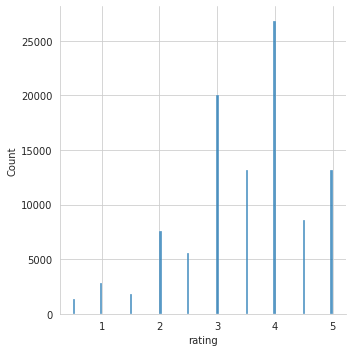

In [0]:
# # bar chart of ratings
# rating_count=movie_ratings.select('rating').toPandas()
# plt.figure(figsize=[12,6])
# plt.violinplot(rating_count.rating)
# plt.title('Ratings Distribution')
# plt.xticks(np.arange(0.5,5.5,0.5))
# plt.show()

import seaborn as sns
rating_count=movie_ratings.select('rating').toPandas()
sns.set_style('whitegrid')
sns.displot(rating_count.rating)

### ALS Model Selection and Evaluation

With the ALS model, I can use a grid search to find the optimal hyperparameters.

In [0]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [0]:
#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [0]:
#Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop", seed = 1)

In [0]:
#Tune model using ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(als.maxIter, [3, 5, 10])\
            .addGrid(als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(als.rank, [5, 10, 15])\
            .build())

In [0]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [0]:
# Build Cross validation 
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5, seed = 1)

In [0]:
#Fit ALS model to training data
cvModel = cv.fit(training)

/databricks/spark/python/pyspark/ml/util.py:886: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
  warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)


In [0]:
 #Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

### Model testing
And finally, make a prediction and check the testing error.

In [0]:
#examine the training data's preformations
prediction_train=bestModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("RMSE for train data = " + str(rmse_train))

RMSE for train data = 0.6379145357048666


In [0]:
#Generate predictions and evaluate using RMSE
prediction_test = bestModel.transform(test)
rmse_test = evaluator.evaluate(prediction_test)
print("RMSE for test data = " + str(rmse_test))

RMSE for test data = 0.8799101666406894


In [0]:
#Print evaluation metrics and model parameters
print ("**Best Model**")
print (" Rank:", str(bestModel._java_obj.parent().getRank())), 
print (" MaxIter:", str(bestModel._java_obj.parent().getMaxIter())), 
print (" RegParam:", str(bestModel._java_obj.parent().getRegParam()))
#print (" Alpha:", str(bestModel._java_obj.parent().getAlpha ()))

**Best Model**
 Rank: 5
 MaxIter: 10
 RegParam: 0.1


In [0]:
prediction_test.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|   4886|   3.0| 3.5795488|
|   148|   4993|   3.0| 3.4066012|
|   148|   7153|   3.0| 3.5840137|
|   148|  31658|   4.0| 3.7108188|
|   148|  50872|   3.0| 3.8965826|
|   148|  54001|   4.0| 3.5150268|
|   148|  72998|   4.0| 3.4719791|
|   148|  76093|   3.0|  3.683958|
|   148|  81847|   4.5| 3.9563408|
|   148|  98243|   4.5|  3.371318|
|   148|  98491|   5.0| 3.7621806|
|   148| 108932|   4.0|   3.60652|
|   148| 115617|   3.5| 3.7563217|
|   148| 116797|   4.5|  3.777235|
|   148| 157296|   3.0|   3.47605|
|   148| 160718|   4.5|  3.702561|
|   463|    527|   4.0| 3.6638417|
|   463|   1092|   3.0| 3.2636814|
|   463|   2006|   3.0| 3.2557673|
|   463|   2167|   3.0|  3.570396|
+------+-------+------+----------+
only showing top 20 rows



### Model apply and see the performance

In [0]:
alldata=bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6910747593801058


In [0]:
alldata.registerTempTable("alldata")

In [0]:
%sql select * from alldata

userId,movieId,rating,prediction
148,356,4.0,3.8424351
148,1197,3.0,3.5780106
148,4308,4.0,3.7349935
148,4886,3.0,3.5795488
148,4896,4.0,3.567729
148,4993,3.0,3.4066012
148,5618,3.0,3.5473142
148,5816,4.0,3.4502199
148,5952,3.0,3.431765
148,6377,3.0,3.849443


In [0]:
%sql select * from movies join alldata on movies.movieId=alldata.movieId

movieId,title,genres,userId,movieId,rating,prediction
356,Forrest Gump (1994),Comedy|Drama|Romance|War,148,356,4.0,3.8424351
1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,148,1197,3.0,3.5780106
4308,Moulin Rouge (2001),Drama|Musical|Romance,148,4308,4.0,3.7349935
4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,148,4886,3.0,3.5795488
4896,Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Adventure|Children|Fantasy,148,4896,4.0,3.567729
4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)",Adventure|Fantasy,148,4993,3.0,3.4066012
5618,Spirited Away (Sen to Chihiro no kamikakushi) (2001),Adventure|Animation|Fantasy,148,5618,3.0,3.5473142
5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,148,5816,4.0,3.4502199
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,148,5952,3.0,3.431765
6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,148,6377,3.0,3.849443


## Recommend moive to users with id: 575, 232. 
choose some users to recommend the moives

In [0]:
!pip install --upgrade pip
!pip install koalas
import databricks.koalas as ks

     |████████████████████████████████| 2.1 MB 5.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1


In [0]:
userRecs = bestModel.recommendForAllUsers(10)

In [0]:
userRecs_ks=userRecs.to_koalas()
movies_ks=movies_df.to_koalas()

In [0]:
def movieRecommendation(inputId):
  recs_list=[]
  for recs in userRecs_ks.loc[str(inputId), 'recommendations']:
    recs_list.append(str(recs[0]))
  return (movies_ks[movies_ks['movieId'].isin(recs_list)])

In [0]:
print("Recommended movies for user with id '575' are as follows.")
movieRecommendation(575)

Recommended movies for user with id '575' are as follows.
/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field recommendations. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType(List(StructField(movieId,IntegerType,true),StructField(rating,FloatType,true))),true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,movieId,title,genres
2523,3379,On the Beach (1959),Drama
4747,7071,"Woman Under the Influence, A (1974)",Drama
5448,26073,"Human Condition III, The (Ningen no joken III)...",Drama|War
5906,33649,Saving Face (2004),Comedy|Drama|Romance
7521,84273,Zeitgeist: Moving Forward (2011),Documentary
8591,117531,Watermark (2014),Documentary
8896,134796,Bitter Lake (2015),Documentary
9042,141718,Deathgasm (2015),Comedy|Horror
9634,179135,Blue Planet II (2017),Documentary
9688,184245,De platte jungle (1978),Documentary


In [0]:
print("Recommended movies for user with id '232' are as follows.")
movieRecommendation(232)

Recommended movies for user with id '232' are as follows.
/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field recommendations. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType(List(StructField(movieId,IntegerType,true),StructField(rating,FloatType,true))),true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,movieId,title,genres
183,215,Before Sunrise (1995),Drama|Romance
2453,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller
4708,7025,"Midnight Clear, A (1992)",Drama|War
4779,7116,Diabolique (Les diaboliques) (1955),Horror|Mystery|Thriller
5032,7834,After the Thin Man (1936),Comedy|Crime|Mystery|Romance
5414,25825,Fury (1936),Drama|Film-Noir
5435,25947,Unfaithfully Yours (1948),Comedy
5489,26326,"Holy Mountain, The (Montaña sagrada, La) (1973)",Drama
5659,27563,"Happiness of the Katakuris, The (Katakuri-ke n...",Comedy|Horror|Musical
9489,170355,Mulholland Dr. (1999),Drama|Mystery|Romance


## Find the similar moives for moive with id: 463, 471
You can find the similar moives based on the ALS results

In [0]:
itemFactors=bestModel.itemFactors.to_koalas()

In [0]:
def similarMovies(inputId, matrix='cosine_similarity'):
  try:
    movieFeature=itemFactors.loc[itemFactors.id==str(inputId),'features'].to_numpy()[0]
  except:
    return 'There is no movie with id ' + str(inputId)
  
  if matrix=='cosine_similarity':
    similarMovie=pd.DataFrame(columns=('movieId','cosine_similarity'))
    for id,feature in itemFactors.to_numpy():
      cs=np.dot(movieFeature,feature)/(np.linalg.norm(movieFeature) * np.linalg.norm(feature))
      similarMovie=similarMovie.append({'movieId':str(id), 'cosine_similarity':cs}, ignore_index=True)
    similarMovie_cs=similarMovie.sort_values(by=['cosine_similarity'],ascending = False)[1:11]
    joint=similarMovie_cs.merge(movies_ks.to_pandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
  if matrix=='euclidean_distance':
    similarMovie=pd.DataFrame(columns=('movieId','euclidean_distance'))
    for id,feature in itemFactors.to_numpy():
      ed=np.linalg.norm(np.array(movieFeature)-np.array(feature))
      similarMovie=similarMovie.append({'movieId':str(id), 'euclidean_distance':ed}, ignore_index=True)
    similarMovie_ed=similarMovie.sort_values(by=['euclidean_distance'])[1:11]
    joint=similarMovie_ed.merge(movies_ks.to_pandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
  return joint[['movieId','title','genres']]

In [0]:
similarMovies(463)

Out[60]: 'There is no movie with id 463'

In [0]:
print('Similar movies based on cosine similarity matrix are as follows.')
similarMovies(471, 'cosine_similarity')

Similar movies based on cosine similarity matrix are as follows.


,movieId,title,genres
0,8910,I Heart Huckabees (2004),Comedy
1,1449,Waiting for Guffman (1996),Comedy
2,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance
3,952,Around the World in 80 Days (1956),Adventure|Comedy
4,2183,"Man Who Knew Too Much, The (1956)",Adventure|Drama|Mystery|Thriller
5,2795,National Lampoon's Vacation (1983),Comedy
6,1282,Fantasia (1940),Animation|Children|Fantasy|Musical
7,5568,Johnny Dangerously (1984),Comedy
8,3055,Felicia's Journey (1999),Thriller
9,2819,Three Days of the Condor (3 Days of the Condor...,Drama|Mystery|Romance|Thriller


In [0]:
print('Similar movies based on euclidean distance matrix are as follows.')
similarMovies(471, 'euclidean_distance')

Similar movies based on euclidean distance matrix are as follows.


,movieId,title,genres
0,8910,I Heart Huckabees (2004),Comedy
1,1449,Waiting for Guffman (1996),Comedy
2,952,Around the World in 80 Days (1956),Adventure|Comedy
3,265,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance
4,2795,National Lampoon's Vacation (1983),Comedy
5,2183,"Man Who Knew Too Much, The (1956)",Adventure|Drama|Mystery|Thriller
6,1282,Fantasia (1940),Animation|Children|Fantasy|Musical
7,943,"Ghost and Mrs. Muir, The (1947)",Drama|Fantasy|Romance
8,4280,"World According to Garp, The (1982)",Comedy|Drama|Romance
9,1271,Fried Green Tomatoes (1991),Comedy|Crime|Drama


## Conclusion

### motivation
For a video service website like Youtube, if more customer are able to find their favorite movies and attractive ads, the website  would build a better reputation and make more money. Therefore, a good recommedation system is important. Based on this idea, I use MovieLens dataset to build a recommendation system myself. I only use small dataset for performance issue. 

The recommendation system is based on Alternating Least Square (ALS) Matrix. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.

The hyperparameters are: 
* maxIter: the maximum number of iterations to run (defaults to 10)
* rank: the number of latent factors in the model (defaults to 10)
* regParam: the regularization parameter in ALS (defaults to 1.0)

The steps to do this project are: 
1. EDA  
Understand the dataset: total number of users, total number of movies, number of movies in each genres.   

2. Preprocess Data   
Only keep movieid, userid and rating for recommedation. Convert data type to integer and float. Seperate the dataset into 80% training and 20% testing.  

3. Build Model     
Fit alternative least square (ALS) model on the training data, tune the hyper-parameter by 5-fold cross validation and grid search. Then evaluate the tuned model by test data.   

4. Output Result and Apply Model    
Output the evaluation result by predict on the test data;  
Use this recommendation system to recommend movie for certain users;  
Use the tuned model to find similar movies for certain movies   

### output and conclusion
The best ALS model's parameters are:  Rank: 5 | MaxIter: 10 | RegParam: 0.1  
The RMSE for training data is 0.6379145357048666   
The RMSE for test data is 0.8799101666406894   
The recommendation system gives top 10 recommendation movies for two users(id: 575, 232). Also, the recommendation system can be used to give similar movies from given movies by cosine similarity and euclidean distance.